# Extracción de Relaciones Temporales en Textos Médicos

### Recorrido por los datos
Vamos a trabajar primero explorando los datos de ejemplo que se proveen con el challenge.
Para eso hacemos uso de la función lift_data(), que extrae anotaciones de relaciones y las combina en una lista junto con el texto original.

In [7]:
from helpers import lift_dataset
# lift_dataset devuelve un iterador
dataset = list(lift_dataset('../dataset/SampleData'))

Veamos algunos tipos de relaciones,

In [8]:
list(dataset)[12]

['EVENT="DISCHARGE" 3:0 3:0',
 'TIMEX3="10-10-94" 4:0 4:0',
 'type="SIMULTANEOUS"\n',
 'DISCHARGE DATE : 10-10-94',
 '386.xml.tlink']

Ahí tenemos dos eventos relacionados mediante la relación 'SIMULTANEOUS', y el texto original dónde aparece.
Veamos otro caso,

In [9]:
list(dataset)[24]

['EVENT="tolerated" 13:2 13:2',
 'EVENT="the procedure" 13:3 13:4',
 'type="OVERLAP"\n',
 'The patient tolerated the procedure well with a 2000 cc. blood loss and was autotransfused two units of blood .',
 '386.xml.tlink']

El set completo de etiquetas se puede encontrar en __[este link.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4237873/table/bau109-T2/?report=objectonly)__


Podemos empezar intentando predecir únicamente las relaciones, esto es, asumiendo que los eventos y las expresiones temporales ya vienen dadas en el dataset de test.

### Estadísticas del dataset
Baje el dataset completo desde la sección __[download de i2b2,](https://www.i2b2.org/NLP/DataSets/Download.php)__ intente levantarlo con el script lift_dataset. Mejore el script si es necesario. <br> Calcule algunas estadísticas, como se señalan abajo,

In [10]:
import pandas as pd

# número de elementos en el dataset (train y test)
dataset_train = list(lift_dataset('../dataset/2012-07-15.original-annotation.release'))
dataset_test = list(lift_dataset('../dataset/ground_truth/merged_i2b2'))

df_train = pd.DataFrame(dataset_train)
df_train.columns = ['event_1', 'event_2', 'relationship', 'text', 'source_file']
print("Train len", len(df_train.index))

df_test = pd.DataFrame(dataset_test)
df_test.columns = ['event_1', 'event_2', 'relationship', 'text', 'source_file']
print("Test len", len(df_test.index))

Train len 33635
Test len 27736


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# distribución de los labels de las relaciones (train y test)
plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
ax = sns.countplot(x="relationship", data=df_train)
ax.set_title("Train")
ax.set_xlabel(xlabel='Relationships', fontsize=16)
ax.set_ylabel(ylabel='Count', fontsize=16)
plt.xticks(rotation='vertical')

plt.subplot(1, 2, 2)
ax = sns.countplot(x="relationship", data=df_test)
ax.set_title("Test")
ax.set_xlabel(xlabel='Relationships', fontsize=16)
ax.set_ylabel(ylabel='Count', fontsize=16)
plt.xticks(rotation='vertical')

plt.tight_layout()


No tenemos todas las relaciones en nuestro conjunto de test.

### Limpiamos datset de test.

In [12]:
import spacy
spacy_nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])
df_test['text_as_doc'] = df_test['text'].apply(lambda x: spacy_nlp(x))
df_test['text_lemma'] = df_test['text_as_doc'].apply(lambda doc: [word.lemma_ for word in doc if word.is_stop == False])

In [13]:
def count(df, col_name, patterns):
    count = sum([len(df[df[col_name].str.contains(pattern, regex=True) == True].index) for pattern in patterns])
    return count

def replace_with_patterns(df, col_name, patterns, replace_with):
    for pattern in patterns:
        df[col_name] = df[col_name].str.replace(pattern, replace_with, regex=True)

In [14]:
# A partir de los lemmas recreamamos el texto bajo una nueva columna que se normalizara.
df_test['text_norm'] = df_test['text_lemma'].apply(lambda x: ' '.join(x))

# lower case
df_test['text_norm'] = df_test['text_norm'].str.lower()

# Cantidad de numeros.
numbers_patterns = ['\d{1,9}\.{0,1}\d{0,4}']
print('Cantidad de numeros en texto original: ', count(df_test, 'text', numbers_patterns))

# Cantidad de fechas.
dates_patterns = ['^\d{4}\s{0,1}-\s{0,1}\d{2}\s{0,1}-\s{0,1}\d{2}$', '\d{4}\s{0,1}-\s{0,1}\d{2}\s{0,1}-\s{0,1}\d{2}', '\d{1,2}\s{0,1}/\s{0,1}\d{1,2}\s{0,1}/\s{0,1}\d{2,4}', '\d{1,2}\s{0,1}-\s{0,1}\d{1,2}']
print('Cantidad de fechas en texto original: ', count(df_test, 'text', dates_patterns))

# normalizamos fechas
replace_with_patterns(df_test, 'text_norm', dates_patterns, 'DATE')
print('Cantidad de fechas en texto normalizado: ', count(df_test, 'text_norm', dates_patterns))

# normalizamos números
replace_with_patterns(df_test, 'text_norm', numbers_patterns, 'NUM')
print('Cantidad de numeros en texto normalizado: ', count(df_test, 'text_norm', numbers_patterns))

print(df_test['text_norm'][:5])

Cantidad de numeros en texto original:  20819
Cantidad de fechas en texto original:  26077
Cantidad de fechas en texto normalizado:  0
Cantidad de numeros en texto normalizado:  0
0                                admission date : DATE
1    admission , patient diagnose acute pancreatitis .
2    patient general good health seven day ago ( DA...
3    patient general good health seven day ago ( DA...
4    DATE patient general good health seven day ago...
Name: text_norm, dtype: object


In [15]:
# limpiamos para que quede solo el nombre de la realcion.
df_test['relationship_norm'] = df_test['relationship']
df_test.relationship_norm = df_test.relationship_norm.str.replace('type="BEFORE"\n', 'BEFORE', regex=True)
df_test.relationship_norm = df_test.relationship_norm.str.replace('type="OVERLAP"\n', 'OVERLAP', regex=True)
df_test.relationship_norm = df_test.relationship_norm.str.replace('type="SIMULTANEOUS"\n', 'SIMULTANEOUS', regex=True)
df_test.relationship_norm = df_test.relationship_norm.str.replace('type="simultaneous"\n', 'SIMULTANEOUS', regex=True)
df_test.relationship_norm = df_test.relationship_norm.str.replace('type="BEFORE_OVERLAP"\n', 'BEFORE_OVERLAP', regex=True)
df_test.relationship_norm = df_test.relationship_norm.str.replace('type="AFTER"\n', 'AFTER', regex=True)
df_test.relationship_norm = df_test.relationship_norm.str.replace('type="DURING"\n', 'DURING', regex=True)
df_test.relationship_norm = df_test.relationship_norm.str.replace('type="BEGUN_BY"\n', 'BEGUN_BY', regex=True)
df_test.relationship_norm = df_test.relationship_norm.str.replace('type="ENDED_BY"\n', 'ENDED_BY', regex=True)
df_test.relationship_norm = df_test.relationship_norm.str.replace('type=""\n', '', regex=True)
print(df_test.relationship_norm.value_counts())

BEFORE     15113
OVERLAP     9894
AFTER       2729
Name: relationship_norm, dtype: int64


In [16]:
# Guardamos datos curados de test.
df_test.to_csv('../dataset/data_test_pos_curacion.csv')

### Cagamos el dataset de train pero desde lo generado en curacion.

In [17]:
df_train = pd.read_csv('../dataset/data_pos_curacion.csv')

### Solo nos vamos a quedar con la relaciones q esstan en el dataset de test.

In [18]:
df_train = df_train[df_train['relationship_norm'].isin(['BEFORE', 'OVERLAP', 'AFTER']) == True]
len(df_train.index)

22739

In [19]:
df_train.columns

Index(['Unnamed: 0', 'event_1', 'event_2', 'relationship', 'text',
       'source_file', 'text_as_doc', 'text_tokens', 'text_lemma', 'text_norm',
       'text_norm_as_doc', 'text_norm_without_punck', 'text_norm_tokens',
       'relationship_norm', 'event_1_type', 'event_2_type', 'event_1_norm',
       'event_2_norm'],
      dtype='object')

### Volvemos a visualizar las distribuciones.

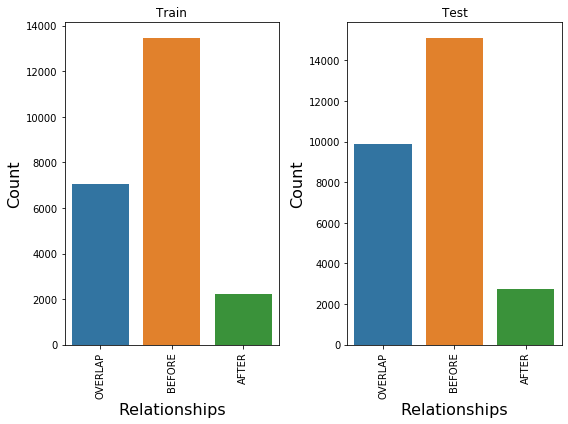

In [20]:
# distribución de los labels de las relaciones (train y test)
plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
ax = sns.countplot(x="relationship_norm", data=df_train)
ax.set_title("Train")
ax.set_xlabel(xlabel='Relationships', fontsize=16)
ax.set_ylabel(ylabel='Count', fontsize=16)
plt.xticks(rotation='vertical')

plt.subplot(1, 2, 2)
ax = sns.countplot(x="relationship_norm", data=df_test)
ax.set_title("Test")
ax.set_xlabel(xlabel='Relationships', fontsize=16)
ax.set_ylabel(ylabel='Count', fontsize=16)
plt.xticks(rotation='vertical')

plt.tight_layout()

Ambos set de datos tienen 'distibuciones' similares.

### Metricas, cantidad de tokens.

In [21]:
spacy_nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])
df_train['text_norm_as_doc'] = df_train['text_norm'].apply(lambda x: spacy_nlp(x))
df_train['text_norm_tokens'] = df_train['text_norm_as_doc'].apply(lambda doc: [token.text for token in doc if token.is_punct == False])
df_train['text_norm_tokens_len'] = df_train['text_norm_tokens'].apply(lambda x: len(x))
df_train['text_norm_tokens_len'].describe()

count    22739.000000
mean        13.316769
std          6.956455
min          1.000000
25%          8.000000
50%         12.000000
75%         17.000000
max         76.000000
Name: text_norm_tokens_len, dtype: float64

In [22]:
df_test['text_norm_as_doc'] = df_test['text_norm'].apply(lambda x: spacy_nlp(x))
df_test['text_norm_tokens'] = df_test['text_norm_as_doc'].apply(lambda doc: [token.text for token in doc if token.is_punct == False])
df_test['text_norm_tokens_len'] = df_test['text_norm_tokens'].apply(lambda x: len(x))
df_test['text_norm_tokens_len'].describe()

count    27736.000000
mean        14.289011
std          9.229395
min          1.000000
25%          8.000000
50%         12.000000
75%         18.000000
max        103.000000
Name: text_norm_tokens_len, dtype: float64

Ambos set de datos tienen muy similares metricas.

### Extracción de Features 
Vamos a extraer features de los datos, para esto se puede utilizar cualquier técnica que crea pertinente.
Como sugerencia se recomienda utilizar los siguientes __[embeddings médicos.](https://github.com/cambridgeltl/BioNLP-2016)__
hint: pruebe de agregar el tipo de evento como feature en el vector.

In [23]:
from gensim.models.keyedvectors import KeyedVectors
embeddings = KeyedVectors.load_word2vec_format('../dataset/PubMed-shuffle-win-2.bin', binary=True)

Otros recursos __[aqui](http://bio.nlplab.org/)__.

In [34]:
# Soporte de tokens en el embedding.
vocab = set()
for tokens in df_train['text_norm_tokens'].tolist():
    for token in tokens:
        vocab.add(token)
oov = set()
oov_total = 0
for token in vocab:
    try:
        embeddings[token]
    except:
        oov_total += 1
        oov.add(token)
print("Tokens fuera del embedding {}% del total del vocabulario.".format((oov_total/len(vocab))*100))

Tokens fuera del embedding 13.848083124328198% del total del vocabulario.


In [40]:
print('NUM' in oov)
print('DATE' in oov)

False
False


In [ ]:
import numpy as np
def sentences_embeddings(model, sentence):
    w_arr = np.empty((0,200), dtype='f')
    for w in sentence:
        try:
            wrd_vector = model[w]
        except:
            wrd_vector = np.random.normal(size=(200,)) 
#                 wrd_vector = np.zeros(200)
        w_arr = np.append(w_arr, np.array([wrd_vector]), axis=0)
    s_mean = np.mean(w_arr, axis=0)
    return s_mean

In [ ]:
df_train['sentence_embedding'] = df_train['text_norm_tokens'].apply(lambda x: sentences_embeddings(embeddings, x))

In [ ]:
df_train['sentence_embedding_len'] = df_train['sentence_embedding'].apply(lambda x: len(x))

In [ ]:
df_train['sentence_embedding_len'].describe()

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_train['relationship_norm'])
print(le.classes_)
print(le.transform(['AFTER', 'BEFORE', 'OVERLAP']))

In [ ]:
df_train['relationship_norm_encoded'] = df_train['relationship_norm'].apply(lambda x: le.transform([x]))

In [ ]:
df_train['relationship_norm_encoded'][:3]

In [ ]:
from sklearn.model_selection import train_test_split
X, y = df_train['sentence_embedding'].to_numpy(), df_train['relationship_norm_encoded'].to_numpy()
X = np.stack(X)
y = np.stack(y)
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=47)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
# Guardamos datos de test/train transformados a features/encoded.
import pickle
with open('../dataset/features_X_train.pkl','wb') as f:
    pickle.dump(X_train, f)
with open('../dataset/X_test.pkl','wb') as f:
    pickle.dump(X_test, f)
with open('../dataset/features_y_train.pkl','wb') as f:
    pickle.dump(y_train, f)
with open('../dataset/features_y_test.pkl','wb') as f:
    pickle.dump(y_test, f)

### Clasificación 
En esta parte vamos a entrenar un clasificador de regresión logística, y vamos a calcular métricas sobre el conjunto de test.

In [65]:
# entrenamiento
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')

exploring_params = {
    'penalty': ['l2'],
    'C': [0.1, 0.01, 0.001, 0.0001],
    'solver': ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs'],
    'class_weight': [None, 'balanced']
}
m = LogisticRegression(random_state=47, multi_class='auto')
model = GridSearchCV(m, exploring_params, cv=5, scoring='accuracy')
model.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=47, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 0.01, 0.001, 0.0001],
                         'class_weight': [None, 'balanced'], 'penalty': ['l2'],
                         'solver': ['liblinear', 'newton-cg', 'sag', 'saga',
                                    'lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       

<Figure size 1120x320 with 0 Axes>

In [66]:
print("Mejor conjunto de parámetros:")
print(model.best_params_, end="\n\n")

print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")

Mejor conjunto de parámetros:
{'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

              precision    recall  f1-score   support

           0       0.39      0.03      0.05       435
           1       0.73      0.89      0.80      2734
           2       0.60      0.51      0.55      1379

    accuracy                           0.69      4548
   macro avg       0.57      0.48      0.47      4548
weighted avg       0.66      0.69      0.65      4548




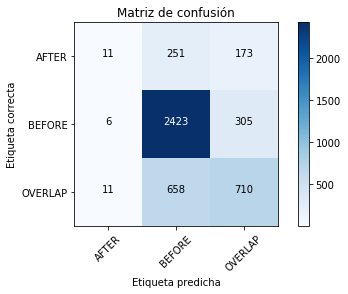

In [67]:
from ml.visualization import plot_confusion_matrix
plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=le.classes_, title="Matriz de confusión")  

En el reporte de clasificacion no vemos buenos numeros en el f1-core para las clases "AFTER" y "OVERLAP". El problema podria no ser linealmente separable y tenemos soportes muy distintos para las distintas clases.

En la matriz de confusion de arriba vemos altos valores por fuera de la diagonal.